# Before your start with this Tutorial

**Tutorial Intention:** Providing an example of iteration and related step on a modeling phase for you to:

*   Experience the data science lifecycle using Vectice
*   See how simple it is to connect your notebook to Vectice
*   Learn how to structure and log your work using Vectice

**Resources needed:**
*   <b>Tutorial Project: Forecast in-store unit sales (22.4)</b> - You can find it as part of your personal workspace named after your name
*   Dataset ready for modeling: https://vectice-examples.s3.us-west-1.amazonaws.com/Tutorial/ForecastTutorial/train_clean.csv
*   Vectice Webapp Documentation: https://docs.vectice.com/
*   Vectice API documentation: https://api-docs.vectice.com/sdk/index.html

## Installing Vectice

In [11]:
%pip install --q vectice -U

Note: you may need to restart the kernel to use updated packages.


## Install optional packages for your project

In [12]:
%pip install --q squarify
%pip install --q plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [13]:
# importing mathematical and ds libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np   # mathematical essentials
%matplotlib inline

# import Visual libraries
import plotly.offline as py
py.init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
#import seaborn as sns  # enhanced graphical output

# Load scikit-learn packages for modeling
from sklearn.model_selection import train_test_split #Split function
from sklearn.linear_model import LinearRegression #LR function
from sklearn.metrics import mean_squared_error,mean_absolute_error

#import the Vectice Library
import vectice
from vectice import FileDataWrapper, DatasetSourceUsage

#importing other libraries
import IPython.display #this is for our data pipeline
import logging
logging.getLogger("vectice").setLevel(logging.WARNING)

##  Vectice Config     
- To log your work to Vectice, you need to connect your notebook to your profile using your personal API token       
- Click on your profile at the top right corner of the Vectice application --> API Tokens --> Create API Token       
- Provide a name and description for the key. We recommend you name the API Token: "Tutorial_API_Token" to avoid having to make additional changes to the notebook.
- Save it in a location accessible by this code

### Update the workspace name below to match the workspace name your project is in

In [14]:
my_vectice = vectice.connect(config=r"Tutorial_API_token.json")
my_workspace = my_vectice.workspace("YOUR WORKSPACE NAME") # replace workspace name
my_project = my_workspace.project("Tutorial Project: Forecast in store unit sales")

## Capture milestones for the Modeling phase

In [15]:
# Let's pick the first step of the Modeling phase
step = my_project.phase("Modeling").iteration().step("Select Modeling Techniques")

# Here we are documenting the modeling technique that we will use on this iteration
step = step.next_step(message="For this first iteration we are going to use a Linear Regression model to get a base model.")


# Linear Regression Model

## Generate Test Design

* [Dataset ready for modeling](https://vectice-examples.s3.us-west-1.amazonaws.com/Tutorial/ForecastTutorial/train_clean.csv)          

     Alternatively, you can generate the dataset from the Data_Preparation code.

In [16]:
#read the dataset
model_ds =pd.read_csv("train_clean.csv")
model_ds = model_ds.fillna(0)

# Set split sizes
test_size = 0.40
# We will set the random seed so we always generate the same split.
random_state = 42

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = model_ds.drop(['unit_sales'], axis=1)
y = model_ds["unit_sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train.to_csv("traindataset.csv")
X_test.to_csv("testdataset.csv")
y_test.to_csv("validatedataset.csv")

step = step.next_step(message="We split the dataset in a training, testing and validation datasets. 40% of the data is set aside for testing and our seed to generate repeatable datasets is 42")


## Build Model

### Linear Regression

In [17]:
#Lets create a linear regression model
model = LinearRegression()

model.fit(X_train.values, y_train.values)
    
pred = model.predict(X_test.values)

print(f"predicted responses:\n {pred}")
    
RMSE = np.sqrt(mean_squared_error(y_test.values, pred))
MAE = mean_absolute_error(y_test.values, pred)

print("root_mean_squared_error: ",RMSE) 
print("mean_absolute_error: ", MAE)

metrics = {"RMSE": RMSE, "MAE": MAE}

predicted responses:
 [-0.08235057  0.25903291  0.13768819 ...  0.09570894  0.17146532
  0.08798382]
root_mean_squared_error:  0.5344943123449198
mean_absolute_error:  0.17817073022658111


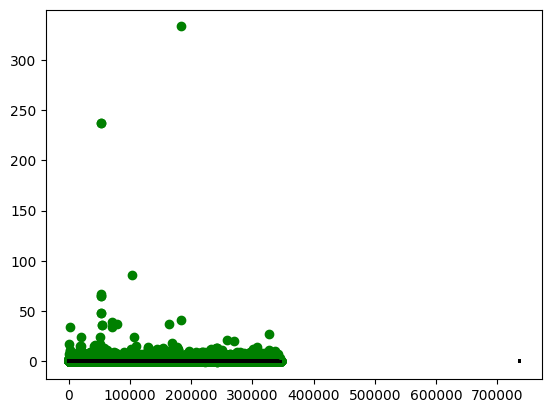

In [18]:
plt.scatter(X_train.iloc[:,0].values, y_train ,color='g') 
plt.plot(X_test, pred,color='k') 
plt.savefig("regression_graph.png")
plt.show()

In [19]:
# Let's log the model we trained along with its metrics, as a new version of the "Regression" model in Vectice.
# Define a testing, training and validation datawrapper
train_ds = FileDataWrapper(name="Modeling Dataset", path="traindataset.csv", usage=DatasetSourceUsage.TRAINING)
test_ds = FileDataWrapper(name="Modeling Dataset", path="testdataset.csv", usage=DatasetSourceUsage.TESTING)
validate_ds = FileDataWrapper(name="Modeling Dataset", path="validatedataset.csv", usage=DatasetSourceUsage.VALIDATION)
step.modeling_dataset = [train_ds, test_ds, validate_ds]

step.iteration.model = vectice.Model(name="Unit Sales Predictor", library="scikit-learn", technique="linear regression", metrics=metrics, attachments="regression_graph.png", predictor=model)
step = step.next_step(message="RMSE= " + str(metrics["RMSE"]) +  " and MAE= " + str(metrics["MAE"])) 

2023/01/27 12:08:22 WARNING vectice.models.step: The code commit exists already.
2023/01/27 12:08:24 WARNING vectice.models.step: The code commit exists already.
2023/01/27 12:08:25 WARNING vectice.models.step: The code commit exists already.
2023/01/27 12:08:34 WARNING vectice.models.iteration: The code commit exists already.


## Assess Model

In [20]:

step.close(message="As expected the model performs better however this is not good enough and we should try a different method. We recommend doing a Random Forest as a new iteration")